In [1]:
from langchain.globals import set_debug,set_verbose

In [ ]:
from langchain_aws import ChatBedrockConverse
from langchain_core.messages import SystemMessage,HumanMessage,AIMessage
model_id = 'anthropic.claude-3-haiku-20240307-v1:0'
llm = ChatBedrockConverse(model=model_id,temperature=0)


### Setup tools

![tools](./images/tools.png)

Dummy data is returned for all 3 tools for demo purposes. In production, the tools can be querying databases for customer data, perform shortest path calculation based on fleet availability and address and also estimate delivery dates based on more factors like weather conditions, public holidays etc.

In [25]:
from langchain_core.pydantic_v1 import BaseModel,Field
from langchain.tools import BaseTool, StructuredTool, tool
from typing import Dict, List, Optional, Type, Union
import datetime
import json

from langchain_core.callbacks import (
    AsyncCallbackManagerForToolRun,
    CallbackManagerForToolRun,
)


# Input Schemas
class CustomerInfoInput(BaseModel):
    id:int = Field(description="customer id")

class DeliveryTrackerInput(BaseModel):
    address:str = Field(description="customer address")

class DateCalculatorInput(BaseModel):
    registration_date:str = Field(description="registration date")
    duration:int = Field(description="days to delivery")

# Output Schemas
class CustomerInfo(BaseModel):
    id:int = Field(description="customer id")
    first_name:str = Field(description="customer first name")
    last_name:str = Field(description="customer last name")
    address:str = Field(description="customer address")
    registration_date:str = Field(description="registration date")

class Delivery(BaseModel):
    address:str = Field(description="address")
    duration:int = Field(description="days to delivery based on address")

class DeliveryDate(BaseModel):
    date:str = Field(description="date of delivery")

# Tools definition
class DeliveryDurationRetriever(BaseTool):
    name = "delivery_duration_retriever"
    description = "retrieve card delivery duration based on customer address."
    args_schema:Type[BaseModel] = DeliveryTrackerInput
    def _run(self,address:str,run_manager: Optional[CallbackManagerForToolRun] = None) -> Delivery:
        delivery_map = [Delivery(address='611789',duration=5),
                      Delivery(address='822134',duration=7)]
        for d in delivery_map:
            if d.address == address:
                return d

class CustomerInfoRetriever(BaseTool):
    name = "customer_info_retriever"
    description = "retrieve customer info based on customer id."
    args_schema:Type[BaseModel] = CustomerInfoInput
    def _run(self,id:int,run_manager: Optional[CallbackManagerForToolRun] = None) -> CustomerInfo:
        profiles = [CustomerInfo(id=1,first_name='jake',last_name='logan',address='611789',registration_date='050324'),
                    CustomerInfo(id=2,first_name='ikebukuro',last_name='shima',address='822134',registration_date='050124')]
        for p in profiles:
            if p.id == id:
                return p

class DateCalculator(BaseTool):
    name = "delivery_date_calculator"
    description = "calculate date of card delivery based on customer registration date and delivery duration"
    args_schema:Type[BaseModel] = DateCalculatorInput
    def _run(self,registration_date:str,duration:int,run_manager: Optional[CallbackManagerForToolRun] = None) -> DeliveryDate:
        d = datetime.datetime.strptime(registration_date, '%d%m%y')
        d = d + datetime.timedelta(days=duration)
        return DeliveryDate(date=d.strftime("%d %B %Y"))

In [4]:
tools = [CustomerInfoRetriever(),DeliveryDurationRetriever(),DateCalculator()]


In [5]:
from langchain import hub
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import SystemMessage

# create_react_agent includes binding of tools
agent_executor = create_react_agent(llm, 
                                    tools, 
                                    messages_modifier=SystemMessage(""""You are a helpful assistant tasked with answering customer queries."""),
                                    debug=False)

### Setup state dict

In [6]:
import operator
from typing import Annotated, List, Tuple, TypedDict

class PlanExecute(TypedDict):
    id:int
    input: str
    intent: str
    grade: int
    ask_human: bool
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

### Setup structured responses

In [7]:

from langchain_core.pydantic_v1 import BaseModel, Field
from typing import Union,Optional

class Intent(BaseModel):
    """Intent of user"""
    
    intent: str = Field(
        description="intent of user"
    )

class Grade(BaseModel):
    """Grade of intent classification"""
    
    grade: int = Field(
        Description="grade of intent classification"
    )

class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

class Response(BaseModel):
    """Response to user."""

    # response: str
    response: str = Field(
        description="response to user"
    )

class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="""Action to perform. Based on past steps, respond to user if information is sufficient; else plan for more steps"""
        
    )

### Define functions for graph nodes

The agent classifies the intent as either 'card delivery' or 'unknown'. 
For 'unknown', the request is routed to the customer to retry.
For 'card delivery', the LLM grades the intent vs the question and a low score routes the request back to the customer to retry. This is useful when there are more categories of intents and when multiple phrases/words can mean the same thing or have nuanced differences which increases chances of misclassification in the first attempt.

In [8]:
def intent_classification(state: PlanExecute):
    system_message = SystemMessage("""For the given statement, classify the intent to either <intent>card delivery</intent> or <intent>unknown</intent>""")
    user_message = HumanMessage(state['input'])
    llm_with_structured_output = llm.with_structured_output(Intent)
    intent = llm_with_structured_output.invoke([system_message,user_message])
    ask_human = False
    if intent.intent == 'unknown':
        ask_human = True
    return {'intent':intent.intent,'id':state['id'],'ask_human':ask_human}

In [9]:
def reflection(state: PlanExecute):
    system_message = SystemMessage("""You are an english teacher. The statement is in <statement></statement> tags and the intent is in <intent></intent> tags. Grade the intent classification from a score of 1 to 5, with 5 being the highest.""")
    user_message = HumanMessage(f"""<statement>{state['input']}</statement><intent>{state['intent']}</intent>""")
    llm_with_structured_output = llm.with_structured_output(Grade)
    grade = llm_with_structured_output.invoke([system_message,user_message])
    ask_human = False
    if grade.grade < 4:
        ask_human = True
    return {'grade':grade.grade,'ask_human':ask_human}

In [10]:
def plan_step(state: PlanExecute):
    print(state)
    system_message = SystemMessage("""For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""")
    if state['intent']=='card delivery':
        user_message = HumanMessage(f'retrieve card delivery date for customer id={state["id"]}')
    llm_with_structured_output = llm.with_structured_output(Plan)
    plan = llm_with_structured_output.invoke([system_message,user_message])
    # return plan
    return {'plan':plan.steps}

In [11]:
def replan_step(state: PlanExecute):
    prompt_template = """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. Respond to the user if no more steps are needed. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
    prompt_filled = prompt_template.format(input=state['input'],plan=state['plan'],past_steps=state['past_steps'])
    human_message = HumanMessage(prompt_filled)
    llm_with_structured_output = llm.with_structured_output(Act)
    replan = llm_with_structured_output.invoke([human_message])
    if isinstance(replan.action,Response):
        return {'response':replan.action.response}
    elif isinstance(replan.action,Plan):
        return {'plan':replan.action.steps}

In [12]:
def execute_step(state: PlanExecute):
    plan = state['plan']
    prompt_template = """For the following plan:
{plan}\n\nYou are tasked with executing step {task}.
The customer id is {id}"""
    prompt_filled = prompt_template.format(plan='\n'.join(plan),task=plan[0],id=state['id'])
    human_message = HumanMessage(prompt_filled)
    agent_response = agent_executor.invoke(
        {"messages": human_message}
    )
    return {
        "past_steps": [(plan[0], agent_response["messages"][-1].content)],
    }
    


In [13]:
# placeholder
def human_node(state: PlanExecute):
    return {'ask_human':False}

In [14]:
def select_node(state: PlanExecute):
    if 'ask_human' in state and state['ask_human']:
        return 'human'
    else:
        return 'continue'

In [15]:
def should_end(state: PlanExecute):
    if 'response' in state and state["response"]:
        return "__end__"
    else:
        return "agent"

In [16]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

In [17]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(PlanExecute)

# Add the intent classification node
workflow.add_node("intent_classification",intent_classification)

# Add the reflection node
workflow.add_node("reflection",reflection)

# Add the human node
workflow.add_node("human",human_node)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)


workflow.add_edge(START, "intent_classification")
# workflow.add_edge("intent_classification","reflection")

workflow.add_conditional_edges(
    "intent_classification",
    select_node,
    {'human':'human','continue':'reflection'}
)

workflow.add_conditional_edges(
    "reflection",
    select_node,
    {'human':'human','continue':'planner'}
)

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    # Pass in the function that will determine which node is called next.
    should_end,
    {'agent':'agent','__end__':END}
)

workflow.add_edge("human","intent_classification")

app = workflow.compile(checkpointer=memory,interrupt_before=["human"])

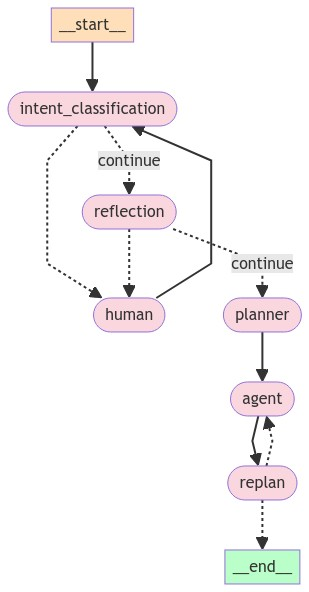

In [18]:
from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

### Intentionally trigger human-in-loop

In [19]:
config = {"configurable": {"thread_id": "1"},"recursion_limit": 15}
# inputs = {"input": "when will my card be delivered?","id":1}
inputs = {"input": "what is the chargeback amount?","id":1}
for event in app.stream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print('k',k)
            print('v',v)
            

k intent_classification
v {'id': 1, 'intent': 'unknown', 'ask_human': True}


In [20]:
snapshot = app.get_state(config)
snapshot.next

('human',)

In [21]:
snapshot.values

{'id': 1,
 'input': 'what is the chargeback amount?',
 'intent': 'unknown',
 'ask_human': True,
 'past_steps': []}

### Update input with different question

In [22]:
app.update_state(config, {"input": "when will my card be delivered?"})

{'configurable': {'thread_id': '1',
  'thread_ts': '1ef4336f-24cc-6388-8002-be1ae24e2cd2'}}

In [23]:
snapshot = app.get_state(config)
snapshot.values

{'id': 1,
 'input': 'when will my card be delivered?',
 'intent': 'unknown',
 'ask_human': True,
 'past_steps': []}

In [24]:
for event in app.stream(None, config=config):
    for k, v in event.items():
        if k != "__end__":
            print('k',k)
            print('v',v)

k human
v {'ask_human': False}
k intent_classification
v {'id': 1, 'intent': 'card delivery', 'ask_human': False}
k reflection
v {'grade': 4, 'ask_human': False}
{'id': 1, 'input': 'when will my card be delivered?', 'intent': 'card delivery', 'grade': 4, 'ask_human': False, 'plan': None, 'past_steps': [], 'response': None}
k planner
v {'plan': ['1. Retrieve customer information for customer with id=1', '2. Identify the card delivery date from the customer information']}
k agent
v {'past_steps': [('1. Retrieve customer information for customer with id=1', "Great, I've retrieved the customer information for the customer with id=1. The key details are:\n- Customer ID: 1\n- First Name: jake\n- Last Name: logan \n- Address: 611789\n- Registration Date: 050324\n\nNow that I have the customer information, I can proceed to step 2 to identify the card delivery date.")]}
k replan
v {'plan': ['2. Identify the card delivery date from the customer information']}
k agent
v {'past_steps': [('2. Ident